Importing library and dataframe

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df=pd.read_csv("Daily.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,15-09-2024,"2,402.04","2,417.56","2,428.91","2,396.68",133.42K,-0.64%
1,14-09-2024,"2,417.56","2,439.29","2,440.40","2,384.99",154.06K,-0.92%
2,13-09-2024,"2,440.12","2,361.79","2,459.47","2,337.76",302.56K,3.32%
3,12-09-2024,"2,361.79","2,340.33","2,387.25","2,316.39",249.29K,0.92%
4,11-09-2024,"2,340.19","2,387.98","2,388.40","2,279.00",333.29K,-1.99%
...,...,...,...,...,...,...,...
3107,14-03-2016,12.50,15.07,15.07,11.40,92.18K,-17.05%
3108,13-03-2016,15.07,12.92,15.07,12.92,1.30K,16.64%
3109,12-03-2016,12.92,11.95,13.45,11.95,0.83K,8.12%
3110,11-03-2016,11.95,11.75,11.95,11.75,0.18K,1.70%


## Data preprocessing

In [8]:
# dropping irrelevant data for regression
def drop_irrelevant(df):
    df=df.drop(["Open","High","Low","Vol.","Change %"],axis=1)
    return df
df = drop_irrelevant(df)

In [3]:
# checking for null values
print(df.isnull().sum())

Date     0
Price    0
dtype: int64


In [9]:
# conversion of date and price to specific datatype
def pre_processing(df):
    # price pre-processing
    for i in range(len(df)):
        if "," in df.loc[i,"Price"]:
            val=df.loc[i,"Price"]
            df.loc[i,"Price"]=float(val[:val.find(",")]+val[val.find(",")+1:])
        else:
            df.loc[i,"Price"]=float(df.loc[i,"Price"])

    # date pre-processing
    from datetime import datetime
    df["Date"]=pd.to_datetime(df["Date"], format='mixed')

    df=df.sort_values(by="Date")
    return df

df = pre_processing(df)

In [10]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool
from bokeh.io import push_notebook


def plot_dataset(df): 
    output_notebook() 


    p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
        background_fill_color="#2F2F2F",  # Dark background
        border_fill_color="#2F2F2F",  # Dark border
        outline_line_color="#FFFFFF"  # Light border)
    )

    # Add a line renderer
    p.line(df['Date'], df['Price'], line_width=2, color='blue', legend_label='Price')

    # Add hover tool
    hover = HoverTool()
    hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
    hover.formatters = {'@x': 'datetime'}
    p.add_tools(hover)

    # Customize axes
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Price ($)'

    # Show the plot
    show(p, notebook_handle=True)

In [ ]:
plot_dataset(df)

Loading BokehJS ...

Converting categorical data to numerical data

In [8]:
# converting date to numerical value for regression task
def encode(df):
    from sklearn.preprocessing import LabelEncoder

    df["Date"]=df["Date"].astype(str)

    le=LabelEncoder()

    unique_values=df["Date"].unique()

    le.fit(unique_values)
    df["Date"]=le.transform(df["Date"])

    return df

df = encode(df)
df


,Date,Price
3089,0,11.62
3059,1,8.75
3028,2,13.85
2998,3,12.35
2967,4,11.08
...,...,...
126,3107,2929.35
95,3108,3559.95
65,3109,3133.33
34,3110,2722.64


In [9]:
df.drop(['Date'], axis= 1, inplace=True)

In [10]:
df.head()

def make_dependence_dataset(df, shift):
    new_df = pd.DataFrame()
    if shift > df.shape[0]:
        return new_df

    for i in range(1,shift + 1):
        new_df[f'Lag_{i}'] = df.shift(i)
    new_df.dropna(inplace=True)
    new_df['target'] = df['Price'].iloc[shift:]
    return new_df


In [11]:
def full_preprocessing(df):
    df = drop_irrelevant(df)
    df = pre_processing(df)
    df = encode(df)
    df.drop(['Date'], axis= 1, inplace=True)
    df.reindex()
    return df

## Ridge Regression

In [12]:
def get_featues_target(df, shift):
    lagged_dataset = make_dependence_dataset(df,shift)
    features = lagged_dataset.drop(['target'], axis = 1)
    target = lagged_dataset['target']
    return features, target

In [13]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import RidgeCV

# import warnings
# # Suppress LinAlgWarning
# warnings.filterwarnings("ignore", Warning)


shifts = [i for i in range(1, 22, 5)]
cvs = [i for i in range(2, 10)]
polys = [i for i in range(1, 4)]

df = pd.read_csv("train.csv")
df = full_preprocessing(df)

test_df = pd.read_csv('test.csv')
test_df = full_preprocessing(test_df)

result = []

for shift in shifts:
    print(f"\n{shift}")
    X_train, y_train = get_featues_target(df, shift)
    X_test, y_test = get_featues_target(test_df, shift)

    # Apply StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for poly in polys:
        poly_transformer = PolynomialFeatures(degree=poly)
        poly_X_train = poly_transformer.fit_transform(X_train)
        poly_X_test = poly_transformer.fit_transform(X_test)
        for cv in cvs:
            rd_model = RidgeCV(alphas=np.logspace(-6, 6, 13),cv=cv)
            rd_model.fit(poly_X_train, y_train)
            score = rd_model.score(poly_X_test, y_test)
            result.append([shift, poly, cv, score])
        print(f"{poly}",end="\t")

result = np.array(result)

        


1
1	2	3	
6
1	2	3	
11
1	2	3	
16
1	2	3	
21
1	2	3	

In [14]:
sorted_ind = result[:,-1].argsort()
result = result[sorted_ind]

In [15]:
best_shift, best_poly , best_cv , _ = result[-1]
best_shift = (int)(best_shift); best_cv = (int)(best_cv); best_poly = (int)(best_poly)
poly_transformer = PolynomialFeatures(degree=best_poly) 

best_rd_model = RidgeCV(cv=best_cv)
X_train, y_train = get_featues_target(df, best_shift)
X_test, y_test = get_featues_target(test_df, best_shift)

poly_X_train = poly_transformer.fit_transform(X_train)
poly_X_test = poly_transformer.fit_transform(X_test)
best_rd_model.fit(poly_X_train,y_train)
y_pred = best_rd_model.predict(poly_X_test)
best_rd_model.score(poly_X_test, y_test)

0.40823923282479446

### Back test

In [43]:
model_back_pred = best_rd_model.predict(poly_X_train)
model_front_pred = best_rd_model.predict(poly_X_test)
def plot_ridge_comparison(y_true,y_pred):
    if y_true.shape[0] != y_pred.shape[0]:
        print(f"incompactible {y_true.shape} {y_pred.shape}")
        return
    output_notebook() 
    x_data = [i for i in range(y_true.shape[0])]

    p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
        background_fill_color="#424242",  # Dark background
        border_fill_color="#2F2F2F",  # Dark border
        outline_line_color="#FFFFFF"  # Light border
    )

    # Add a line renderer
    p.line(x_data, y_true, line_width=2, color='#F57F17', legend_label='True')
    p.line(x_data, y_pred, line_width=2, color='#AB47BC', legend_label='Predicted')

    # Add hover tool
    hover = HoverTool()
    p.add_tools(hover)

    # Customize axes
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Price ($)'

    # Show the plot
    show(p, notebook_handle=True)

plot_ridge_comparison(y_train, model_back_pred)
plot_ridge_comparison(y_test, model_front_pred)

Loading BokehJS ...

Loading BokehJS ...

### front-test with prediction

In [65]:
from typing import Optional
import warnings

# Suppress LinAlgWarning from numpy
warnings.filterwarnings("ignore", category=UserWarning)


def front_test_pred(model, X_test:np.ndarray, transformer, till:Optional[int] = None):
    y_pred = []
    next_pred_on = list(X_test[0])
    length = X_test.shape[0]
    if till:
        length = till
    print(transformer.transform([next_pred_on]))
    for i in range(length):
        pred = model.predict(transformer.transform([next_pred_on]))[0]
        # print(pred)
        y_pred.append(pred)
        next_pred_on = next_pred_on[1:]
        next_pred_on.append(pred)
    return np.array(y_pred)


In [69]:
front_y_pred = front_test_pred(best_rd_model, np.array(X_test), poly_transformer, 50)

[[1.00000e+00 3.81595e+03 2.97327e+03 3.50282e+03 3.43351e+03 2.30428e+03
  2.35203e+03]]


In [70]:
plot_ridge_comparison(y_test.iloc[:50], front_y_pred)
plot_ridge_comparison(y_test, np.zeros(y_test.shape))

Loading BokehJS ...

Loading BokehJS ...

### Inference

Ridge Regression performs well in preddicting whether the values will go 'RISE' or 'FALL', but it performs very bad in predicting the next actual values. 

# AUTO And ARIMA

In [12]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df=pd.read_csv("Daily.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,15-09-2024,"2,402.04","2,417.56","2,428.91","2,396.68",133.42K,-0.64%
1,14-09-2024,"2,417.56","2,439.29","2,440.40","2,384.99",154.06K,-0.92%
2,13-09-2024,"2,440.12","2,361.79","2,459.47","2,337.76",302.56K,3.32%
3,12-09-2024,"2,361.79","2,340.33","2,387.25","2,316.39",249.29K,0.92%
4,11-09-2024,"2,340.19","2,387.98","2,388.40","2,279.00",333.29K,-1.99%
...,...,...,...,...,...,...,...
3107,14-03-2016,12.50,15.07,15.07,11.40,92.18K,-17.05%
3108,13-03-2016,15.07,12.92,15.07,12.92,1.30K,16.64%
3109,12-03-2016,12.92,11.95,13.45,11.95,0.83K,8.12%
3110,11-03-2016,11.95,11.75,11.95,11.75,0.18K,1.70%


Data preprocessing

In [13]:
# dropping irrelevant data for regression
df=df.drop(["Open","High","Low","Vol.","Change %"],axis=1)
df

,Date,Price
0,15-09-2024,"2,402.04"
1,14-09-2024,"2,417.56"
2,13-09-2024,"2,440.12"
3,12-09-2024,"2,361.79"
4,11-09-2024,"2,340.19"
...,...,...
3107,14-03-2016,12.50
3108,13-03-2016,15.07
3109,12-03-2016,12.92
3110,11-03-2016,11.95


In [14]:
# checking for null values
print(df.isnull().sum())

Date     0
Price    0
dtype: int64


In [15]:
# conversion of date and price to specific datatype

# price pre-processing
for i in range(len(df)):
    if "," in df.loc[i,"Price"]:
        val=df.loc[i,"Price"]
        df.loc[i,"Price"]=float(val[:val.find(",")]+val[val.find(",")+1:])
    else:
        df.loc[i,"Price"]=float(df.loc[i,"Price"])

# date pre-processing
from datetime import datetime
df["Date"]=pd.to_datetime(df["Date"])

df=df.sort_values(by="Date")

In [16]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool
from bokeh.io import push_notebook

output_notebook() 


p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
    background_fill_color="#2F2F2F",  # Dark background
    border_fill_color="#2F2F2F",  # Dark border
    outline_line_color="#FFFFFF"  # Light border)
)

# Add a line renderer
p.line(df['Date'], df['Price'], line_width=2, color='blue', legend_label='Price')

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
hover.formatters = {'@x': 'datetime'}
p.add_tools(hover)

# Customize axes
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price ($)'

# Show the plot
show(p, notebook_handle=True)

Loading BokehJS ...

Converting categorical data to numerical data

In [50]:
# converting date to numerical value for regression task

# from sklearn.preprocessing import LabelEncoder

# df["Date"]=df["Date"].astype(str)

# le=LabelEncoder()

# unique_values=df["Date"].unique()

# le.fit(unique_values)
# df["Date"]=le.transform(df["Date"])

df


,Date,Price
3111,2016-03-10,11.75
3110,2016-03-11,11.95
3109,2016-03-12,12.92
3108,2016-03-13,15.07
3107,2016-03-14,12.5
...,...,...
4,2024-09-11,2340.19
3,2024-09-12,2361.79
2,2024-09-13,2440.12
1,2024-09-14,2417.56


Auto Regression

Finding auto_correlation to get number of Lag features

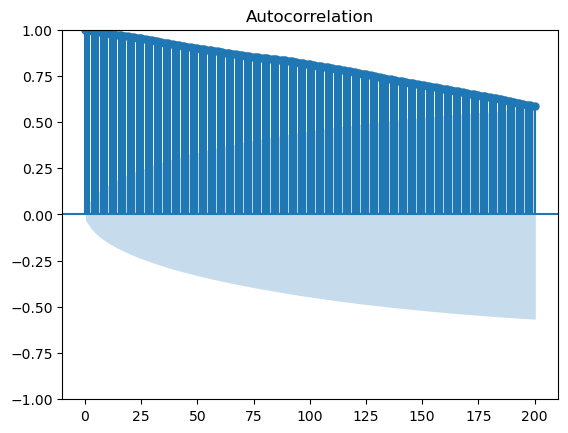

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
series=df["Price"]
plot_acf(series,lags=200)
plt.show()

Thus 200 Lag features are sufficient for us

Creating Lag features and dropping rows with NULL values

In [18]:
# Creating a true copy
df_v=df.copy()

# Inserting Lag features into the copy 
for i in range(1,201):
    df_v[f'Lag_{i}']=df["Price"].shift(i)

# Dropping rows with NULL values
df_v.dropna(inplace=True)

# Split the data into training and testing sets
# such that first 80% of data is train and
# rest 20% is test
train_size = int(0.8 * len(df_v))
train_data = df_v[:train_size]
test_data = df_v[train_size:]
 
# Define the input features (lag features) and target variable
y_train = train_data["Price"]
y_test = test_data["Price"]

Training the model with Training data

In [19]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

# Fitting with 200 Lag features as chosen above
ar_model=AutoReg(np.array(y_train),lags=200)
ar_results=ar_model.fit()

Predicting on test set and finding MAE,MSE,MAPE

In [20]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1, dynamic=False)
 
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape=mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Error:",mae)
print("Root Mean Squared Error:",rmse)
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 1183.9420245269419
Root Mean Squared Error: 1418.652687037064
Mean Absolute Percentage Error: 0.4472707868653245


Plotting and Comparing Predicted values with Real data

In [21]:
output_notebook() 

p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
    background_fill_color="#2F2F2F",  # Dark background
    border_fill_color="#2F2F2F",  # Dark border
    outline_line_color="#FFFFFF"  # Light border)
)

# Add a line renderer
p.line(test_data["Date"],test_data["Price"], line_width=2, color="blue", legend_label="True Price")
p.line(test_data["Date"],y_pred,line_width=2,color="red",legend_label="Predicted Price")

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
hover.formatters = {'@x': 'datetime'}
p.add_tools(hover)

# Customize axes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price ($)"

# Show the plot
show(p, notebook_handle=True)

Loading BokehJS ...

ARIMA Model

Extracting Lag features and Price to pass to ARIMA Model for both train and test

In [22]:
from statsmodels.tsa.arima.model import ARIMA

x_train = train_data[[f'Lag_{i}' for i in range(1, 201)]]
x_train=np.array(x_train,dtype="float64")

x_test=test_data[[f'Lag_{i}' for i in range(1, 201)]]
x_test=np.array(x_test,dtype="float64")

y_train = np.array(train_data["Price"],dtype="float64")


Training the model on the given Lag features and Price

In [23]:
arima_model = ARIMA(y_train, order=(0, 0, 1),exog=x_train)
arima_result=arima_model.fit()

Predicting on Test data by passing Lag features

In [24]:
y_pred=arima_result.forecast(steps=len(test_data),exog=x_test)

Computing MSE,MAE,MAPE

In [25]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape=mean_absolute_percentage_error(y_test,y_pred)
print("Mean Absolute Error:",mae)
print("Root Mean Squared Error:",rmse)
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 57.160281920869394
Root Mean Squared Error: 84.06345814596662
Mean Absolute Percentage Error: 0.02360969395038861


Plotting and Comparing Predicted values with Real data

In [26]:
output_notebook() 

p = figure(width=1150, height=600, x_axis_type='datetime', title='Interactive Date vs Price Plot',
    background_fill_color="#2F2F2F",  # Dark background
    border_fill_color="#2F2F2F",  # Dark border
    outline_line_color="#FFFFFF"  # Light border)
)

# Add a line renderer
p.line(test_data["Date"],y_test, line_width=2, color="blue", legend_label="True Price")
p.line(test_data["Date"],y_pred,line_width=2,color="red",legend_label="Predicted Price")

# Add hover tool
hover = HoverTool()
hover.tooltips = [("Date", "@x{%F}"), ("Price", "@y")]
hover.formatters = {'@x': 'datetime'}
p.add_tools(hover)

# Customize axes
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price ($)"

# Show the plot
show(p, notebook_handle=True)

Loading BokehJS ...

# HMM

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("Daily.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,15-09-2024,"2,402.04","2,417.56","2,428.91","2,396.68",133.42K,-0.64%
1,14-09-2024,"2,417.56","2,439.29","2,440.40","2,384.99",154.06K,-0.92%
2,13-09-2024,"2,440.12","2,361.79","2,459.47","2,337.76",302.56K,3.32%
3,12-09-2024,"2,361.79","2,340.33","2,387.25","2,316.39",249.29K,0.92%
4,11-09-2024,"2,340.19","2,387.98","2,388.40","2,279.00",333.29K,-1.99%
...,...,...,...,...,...,...,...
3107,14-03-2016,12.50,15.07,15.07,11.40,92.18K,-17.05%
3108,13-03-2016,15.07,12.92,15.07,12.92,1.30K,16.64%
3109,12-03-2016,12.92,11.95,13.45,11.95,0.83K,8.12%
3110,11-03-2016,11.95,11.75,11.95,11.75,0.18K,1.70%


In [ ]:
# removing the non_relevant columns
df.drop(columns = ['Vol.', 'Change %'],inplace = True)
#  removing the commas in price
for i in range(len(df)):
    for j in df.columns[1:]:
        if "," in df.loc[i,j]:
            val=df.loc[i,j]
            df.loc[i,j]=float(val[:val.find(",")]+val[val.find(",")+1:])
        else:
            df.loc[i,j]=float(df.loc[i,j])

# date pre-processing
from datetime import datetime
df["Date"]=pd.to_datetime(df["Date"],dayfirst=True)

df=df.sort_values(by="Date")
df

,Date,Price,Open,High,Low
3111,2016-03-10,11.75,11.2,11.85,11.07
3110,2016-03-11,11.95,11.75,11.95,11.75
3109,2016-03-12,12.92,11.95,13.45,11.95
3108,2016-03-13,15.07,12.92,15.07,12.92
3107,2016-03-14,12.5,15.07,15.07,11.4
...,...,...,...,...,...
4,2024-09-11,2340.19,2387.98,2388.4,2279.0
3,2024-09-12,2361.79,2340.33,2387.25,2316.39
2,2024-09-13,2440.12,2361.79,2459.47,2337.76
1,2024-09-14,2417.56,2439.29,2440.4,2384.99


In [10]:
# converting date to numerical value for regression task

from sklearn.preprocessing import LabelEncoder

df["Date"]=df["Date"].astype(str)

le=LabelEncoder()

unique_values=df["Date"].unique()

le.fit(unique_values)
df["Date"]=le.transform(df["Date"])
df

,Date,Price,Open,High,Low
3111,0,11.75,11.2,11.85,11.07
3110,1,11.95,11.75,11.95,11.75
3109,2,12.92,11.95,13.45,11.95
3108,3,15.07,12.92,15.07,12.92
3107,4,12.5,15.07,15.07,11.4
...,...,...,...,...,...
4,3107,2340.19,2387.98,2388.4,2279.0
3,3108,2361.79,2340.33,2387.25,2316.39
2,3109,2440.12,2361.79,2459.47,2337.76
1,3110,2417.56,2439.29,2440.4,2384.99


In [11]:
# test data set , predict the price for next test_days = 100 days
test_days = 100
test_dataset  = df.iloc[-test_days:,:].copy()
test_dataset.drop(columns=['Date'],inplace=True)
train_dataset = df.iloc[:-test_days,:].copy()
train_dataset.drop(columns=['Date'],inplace=True)
train_dataset

,Price,Open,High,Low
3111,11.75,11.2,11.85,11.07
3110,11.95,11.75,11.95,11.75
3109,12.92,11.95,13.45,11.95
3108,15.07,12.92,15.07,12.92
3107,12.5,15.07,15.07,11.4
...,...,...,...,...
104,3767.1,3782.06,3849.47,3759.07
103,3810.35,3767.1,3831.41,3743.11
102,3865.14,3810.35,3885.15,3778.13
101,3812.95,3865.15,3878.28,3765.23


In [15]:
from hmmlearn import hmm
# maximum number of iteration model perform : Max_iter
Max_iter = 1000
# best number of hidden states for GaussianHMMmodel
def best_n_states(HiddenStates):
    # to reduce computational complexity Covarience matrix type is diag
    model = hmm.GaussianHMM(n_components=HiddenStates,covariance_type='diag', n_iter=Max_iter)
    model.fit(train_dataset.values)
    
    num_model_params = HiddenStates**2 + HiddenStates
    """
    We are using Baysion Information criterion to select
    the number of states in fianl model.
    (models with lower BIC are generally preferred).
    bic = -2(log(P(train_dataset)))-num_models_params(log(number of observation samples))
    """
    bic = -2*model.score(train_dataset)+num_model_params*np.log(train_dataset.shape[0])
    return bic

best_number_states=0
bic = float('inf')
for i in range(2,7):
    temp_bic = best_n_states(i)
    if(temp_bic<bic):
        best_number_states = i
        bic = temp_bic
        
print("best number of states for GaussinaHMM is :",best_number_states)

best number of states for GaussinaHMM is : 6


In [16]:
"""
find similar likelihood to given likelihood in past observation.
curr here is representing the day at which original likelihood is calculated.
the obervation among all whose difference with original_likelihood
is minimum will be of similar likelihood,that will be known as here 
similar_observation.
"""

def simlrllhdinpast(curr,original_likelihood,model,K):
    similar_likelihood  = 0
    similar_observation = 0
    
    # minimum difference between log-likelihood of curr observation and nth observation 
    mindiff = float('inf')  
    for n in range(curr-2,-1,-1):
        if(n<K):
            break
        local_trn_data = train_dataset.iloc[n-K:n,:].values
        new_likelihood = model.score(local_trn_data)
        diff = abs(new_likelihood - original_likelihood)
        if diff < mindiff:
            mindiff = diff
            similar_observation = n
            similar_likelihood  = new_likelihood
    
    if similar_observation + 1 >=train_dataset.shape[0]:
        raise IndexError("Similar observation is at the end of the dataset. Cannot access next observation.")
    #calculate the predicted price for curr observation
    
    price = (
        train_dataset['Price'].iloc[curr-1]
        + (train_dataset['Price'].iloc[similar_observation] - train_dataset['Price'].iloc[similar_observation+ 1])
        * np.sign(original_likelihood - similar_likelihood)
    )
    # here multiplying with sign ensures that whether price will increase or decrease by difference in magnitude 
    
    return price,similar_observation

In [17]:
# by sliding window approach to predict the future prices of test_days = 100 days

# number of observation : N
N = train_dataset.shape[0]
# size of sliding window(training window) : K
K = 100
predicted_price = []

# Initialize model parameters

model = None
for n in range(N,N+test_days):
    #train the GaussianHMM using best number of hidden states
    #on data from n-K to n
    local_trn_data = train_dataset.iloc[n-K:n,:].values

    # for the first time trainig the model we need the default
    # initialisation of start probabilities, transition matrix
    # mean and covariences.
    np.random.seed(150)
    
    if(n == N):
        model = hmm.GaussianHMM(n_components=best_number_states,n_iter=Max_iter)
    else:
        # retune the model by using the HMM parameters from the previous iterations 
        # as prior(starting point for training on the new data).
        oldmodel = model
        model = hmm.GaussianHMM(n_components=best_number_states,n_iter=Max_iter,init_params='c')
        model.transmat_  = oldmodel.transmat_
        model.startprob_ = oldmodel.startprob_
        model.means_     = oldmodel.means_
        
    model.fit(local_trn_data)

    #log-likelihood of previous K observation
    original_likelihood = model.score(local_trn_data)
    
    # find similar likelihood to given likelihood in past observation
    # and then predict price
    pred_price_and_similarpoint = simlrllhdinpast(n, original_likelihood, model,K)    
    predicted_price.append(pred_price_and_similarpoint[0])
    
    # after each iteration our train data will increase by one with true observation 
    # Update train_dataset with new observed data (make sure you access the correct index)
    new_data = test_dataset.iloc[n - N].to_frame().T  # Ensure it's a DataFrame with one row
    train_dataset = pd.concat([train_dataset, new_data], ignore_index=True)

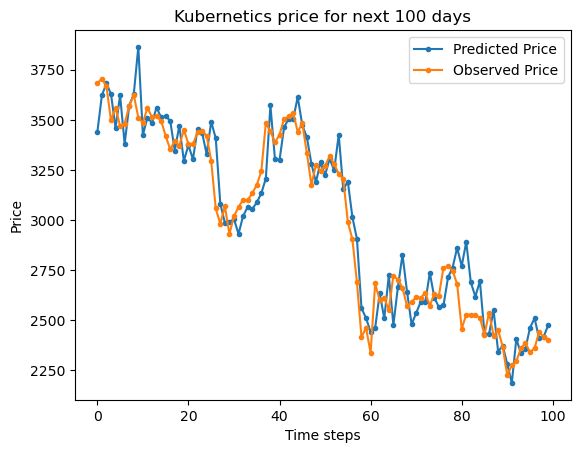

Mean Absolute Percentage Error for This HMM model is :  3.4293116658954492


In [ ]:
True_Price = []
for i in test_dataset['Price']:
  True_Price.append(i)

"""
MAPE calculation:
    The N will be here test_days i.e for how many next days we are 
    predicting price using previous true data.
"""

def mape_calc(predicted_price,True_Price):
    MAPE = 0
    test_days = len(True_Price)

    for i in range(test_days):
        MAPE = MAPE + ((abs(predicted_price[i]-True_Price[i])/True_Price[i])/test_days)*100
    return MAPE

import matplotlib.pyplot as plt

def plot_graph(predicted_price,True_Price):
    plt.plot(predicted_price,marker='.', label = "Predicted Price")
    plt.plot(True_Price,marker = '.', label= "Observed Price")
    plt.title("Kubernetics price for next 100 days")
    plt.ylabel("Price")
    plt.xlabel("Time steps")
    plt.legend()
    plt.show()
    MAPE = mape_calc(predicted_price,True_Price)
    print("Mean Absolute Percentage Error for This HMM model is : ",MAPE)
plot_graph(predicted_price,True_Price)

Performance Metrics used for HMM model is Mean Absolute Percentage Error (MAPE)
which is defined as:   
$$
\text{MAPE} = \frac{1}{N} \sum_{i=1}^{N} \left| \frac{\text{Predicted}(i) - \text{True}(i)}{\text{True}(i)} \right| \times 100
$$
As it Low Performance is High

observation:
"""
This Method (Sliding Window Approach for Time Series and using the true value of predicted day for prediction of next day)
is excellent performing in prediction of nature of market(bearish,bullish) and also in Price Prediction.
We can See that model have MAPE 3.6 which very less.
"""

100


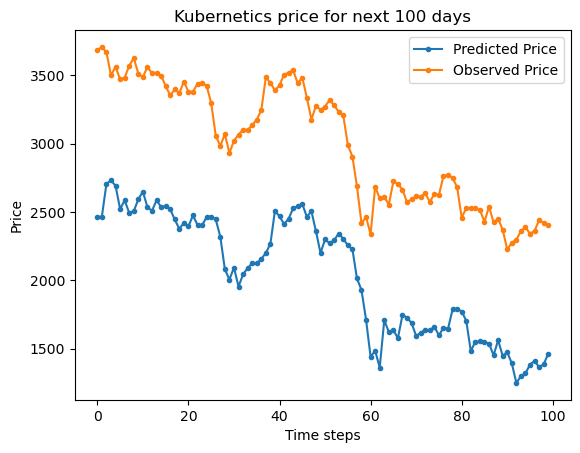

Mean Absolute Percentage Error for This HMM model is :  32.53518246428224


In [19]:
"""
Now going to predict next hundred days market price using only train_dataset,
in this method model will not use true value of the predicted day unlike
in previous model.
"""

# same as initial train_dataset
new_train_data = train_dataset.iloc[:-test_days,:]  
                                
model = hmm.GaussianHMM(n_components=best_number_states,covariance_type='diag', n_iter=Max_iter)


new_N = len(new_train_data)
new_K = len(test_dataset)

local_trn_data = train_dataset.iloc[new_N-new_K:new_N,:].values
model.fit(local_trn_data)

likelihood = model.score(local_trn_data)

similar_obs = simlrllhdinpast(N-1,likelihood, model,new_K)[1]

new_predicted_price = [train_dataset['Price'].iloc[-1]]

for i in range(len(test_dataset)):
    price =(new_predicted_price[-1]
        + (train_dataset['Price'].iloc[similar_obs+i+1] - train_dataset['Price'].iloc[similar_obs+i]))
    new_predicted_price.append(price)

new_predicted_price = new_predicted_price[1:]
print(len(new_predicted_price))
plot_graph(new_predicted_price,True_Price)

Observation:
"""
By observing graph we can say that HMM is very nice model for predicting that, for next n days 
what will be the nature of market, market will be up or down, it have erro in predicting price but 
have nice prediction in market nature.
"""

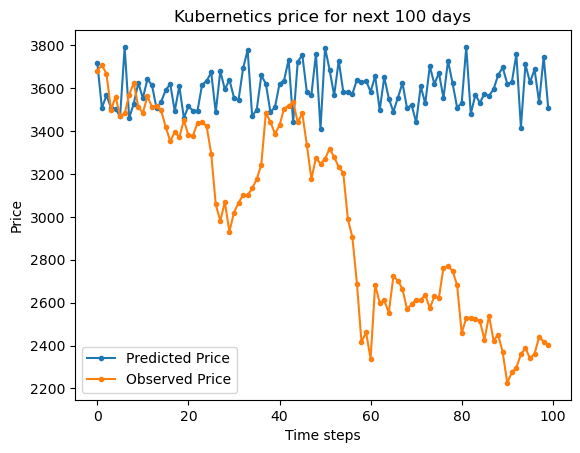

Mean Absolute Percentage Error for This HMM model is :  23.19638011329972


In [20]:
model = hmm.GaussianHMM(n_components=best_number_states,covariance_type='diag', n_iter=Max_iter)
model.fit(new_train_data.values)

"""
Since Model is trained we can use the observation generated by model to predict the 
price.
For this we use model.sample() and get the predicted price change for 100(test_days) days.
and adding the price change in last sample from train_data_set we will predict price for current day.
->last sample from train_data_set is act as reference
"""

predicted_changes = model.sample(len(test_dataset))[0]

#using the last training price for predicting price for first next day
new_predicted_price = []

for pred_change in predicted_changes:
    #pred_change[0] correspond to change for 'Price'
    new_predicted_price.append(new_train_data['Price'].iloc[-1]+pred_change[0])


plot_graph(new_predicted_price,True_Price)

observation:
    """
    Here we can see that price prediction is very worse, but okayish in predicting the market nature,
    .i.e, up or down
    """